In [1]:
import glob
import json
import os

import py3Dmol
import acpype
import MDAnalysis as mda
import nglview as nv
import numpy as np
import openbabel.pybel as pybel
from parmed import amber, gromacs
from acpype.topol import ACTopol, MolTopol
from IPython.display import HTML, display
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import HTML, display

IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (1200, 400)



## Получение itp фаила

In [2]:
def mol_to_smi(input_path: str, output_path: str):
    """
    Converts a molecular file from one format to another using openbabel.pybel.

    This function reads a molecule from a specified input file and writes it to an output file in a different format.
    Both the input and output formats are determined by the file extensions of the respective file paths provided.

    Parameters:
        input_path (str): The file path for the input molecule file, including its extension which determines the input format.
        output_path (str): The file path for the output molecule file, including its extension which determines the output format.

    Returns:
        None: The function does not return a value but writes the converted molecule to the output file.

    Example:
        mol_converter("input.mol2", "output.smi")  # Converts from Mol2 to SMILES format.
    """
    input_format = input_path.split('.')[-1]
    output_format = output_path.split('.')[-1]
    molecule = next(pybel.readfile(input_format, input_path))
    molecule.write(output_format, output_path, overwrite=True)
    
    if output_format == 'smi':
        with open(output_path) as f:
            smi_str = f.readline()
        return smi_str

In [3]:
def show_smi(smi, style='stick', addh= True):
    mol = Chem.MolFromSmiles(smi)
    if addh:
        mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=1000, height=300)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()

In [4]:
def show_mol2(mol2, maxIters=200, addh= True):
    mol = Chem.MolFromMol2File(mol2)
    if addh:
        mol = Chem.AddHs(mol)

    # Оптимизация 3D-структуры 
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=maxIters)
    
    # Создание объекта для 3D-визуализации
    view = py3Dmol.view(width=600, height=400)

    # Добавление модели молекулы
    mblock = Chem.MolToMolBlock(mol)
    view.addModel(mblock, 'mol')

    # Настройка стиля
    view.setStyle({'stick': {}})

    # Масштабирование и отображение
    view.zoomTo()
    view.show()

In [5]:
def smi_to_mol2(smi_input, output_format, file_name=None, addh=True):
    """
    Converts an SMI string or file to a molecule file format (mol2, mol, mdl).

    Args:
      smi_input: The SMI string or path to an SMI file.
      output_format: The desired output format (mol2, mol, mdl).
      file_name (optional): The desired output file name (excluding extension).

    Returns:
      None. Raises an error for invalid input or format.
    """

    valid_formats = ['mol2', 'mol', 'mdl']
    if output_format not in valid_formats:
        raise ValueError(f"Invalid output format: {output_format}")
        
    # Check if SMI is a string
    if not isinstance(smi_input, str):
        raise TypeError("Input must be a string")

    # Read SMI string from file or argument
    if smi_input.lower().endswith('.smi') or smi_input.lower().endswith('.smiles') :
        with open(smi_input) as file:
            smi_str = file.read().strip()
    else:
        smi_str = smi_input.strip()
        if file_name is None:
            file_name = 'convert_mol' 

    # Print current molecule
    print(f"Current molecule: {smi_str}")

    # Create molecule, add hydrogens, and generate 3D coordinates
    mol = pybel.readstring("smi", smi_str)
    if  addh:
        mol.addh()
    mol.make3D()

    # Construct output path based on input and arguments
    output_path = file_name + '.' + output_format if file_name else smi_input.split('.')[0] + '.'+output_format

    # Write molecule to file
    mol.write(output_format, output_path, overwrite=True)
    print('output path:',output_path)

#### Часть ковейера где на вход подается smi фаил или строка а на выход выдается папка acpype с сырым itp

In [6]:
# переводим smi в mol для psiresp 
smi_to_mol2('moleculse/R_CIT.smi', 'mol2',  addh=False)

show_mol2('moleculse/arginine_citrullination_out_H.mol2', maxIters=300,  addh=False)

FileNotFoundError: [Errno 2] No such file or directory: 'moleculse/R_CIT.smi'

In [7]:
show_mol2('moleculse/R_CIT.mol2', maxIters=300,  addh=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [20]:
# os.chdir("_projects/2022_md_FRET_nv/param_R_CIT")

In [14]:
# os.chdir('../')

In [21]:
!pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


In [16]:
# Проверяем существование папки Acpype и создаём её, если нужно
basename = 'RCIT'
# Путь к файлу MDL, который будет создан
molecul = 'moleculse/R_CIT.mol2'
# molecul = 'moleculse/R_CIT.smi'
# Создание объекта ACTopol и выполнение методов
molecule = ACTopol(molecul, chargeType="gas", atomType='gaff', outTopol='gmx',
                   basename=basename, chargeVal=0)


molecule.createACTopol()
molecule.createMolTopol()


==> ... charge set to 0
==> Executing Antechamber...
==> AC output file present... doing nothing
==> * Antechamber OK *
==> * Parmchk OK *
==> Topologies files already present... doing nothing
==> * Tleap OK *
==> Removing temporary files...
==> Using OpenBabel v.3.1.0

==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

==> Pickle file RCIT.pkl already present... doing nothing
==> Removing temporary files...


#### Получили папку 

## Подготавливаем 

#### Теперь надо сделать соответствие атомов в стандартом остатке аминокислоты с атомами в модифицированном

На вход тот же smi 

In [8]:
def open_smi(path):
    with open (path, 'r') as f:
        return f.readline()

In [10]:
u = mda.Universe('moleculse/aminoacids_template/RRR.pdb')
sel = u.select_atoms('resnum 1')
sel.write('moleculse/aminoacids_template/NR.pdb')

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


[20:32:27] Molecule does not have explicit Hs. Consider calling AddHs()
[20:32:27] Molecule does not have explicit Hs. Consider calling AddHs()


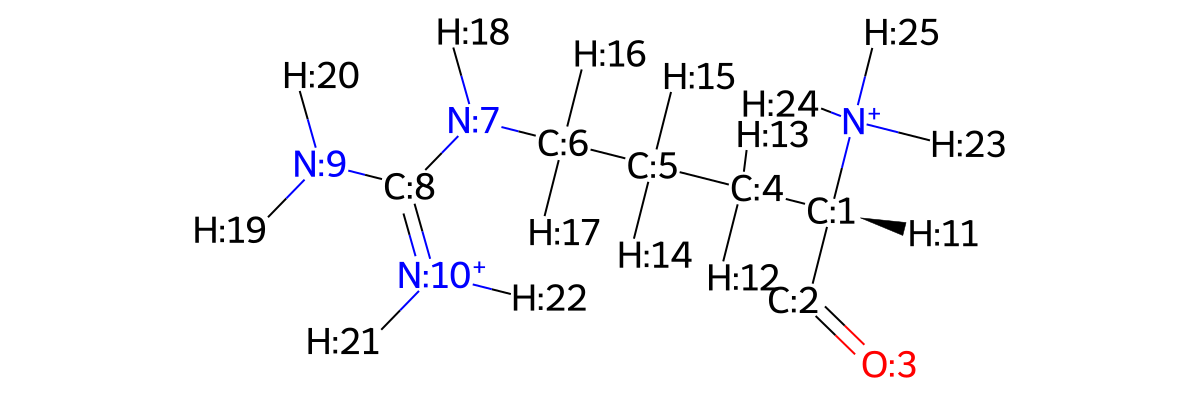

In [33]:
R_pdb = Chem.MolFromPDBFile('moleculse/aminoacids_template/NR.pdb', removeHs=False)
AllChem.EmbedMolecule(R_pdb)
AllChem.MMFFOptimizeMolecule(R_pdb)

# Преобразование трехмерных координат в двумерные
AllChem.Compute2DCoords(R_pdb)
# Отображение молекулы
for i, atom in enumerate(R_pdb.GetAtoms()):
    atom.SetAtomMapNum(atom.GetIdx())
display(R_pdb)

[20:32:46] Molecule does not have explicit Hs. Consider calling AddHs()
[20:32:46] Molecule does not have explicit Hs. Consider calling AddHs()


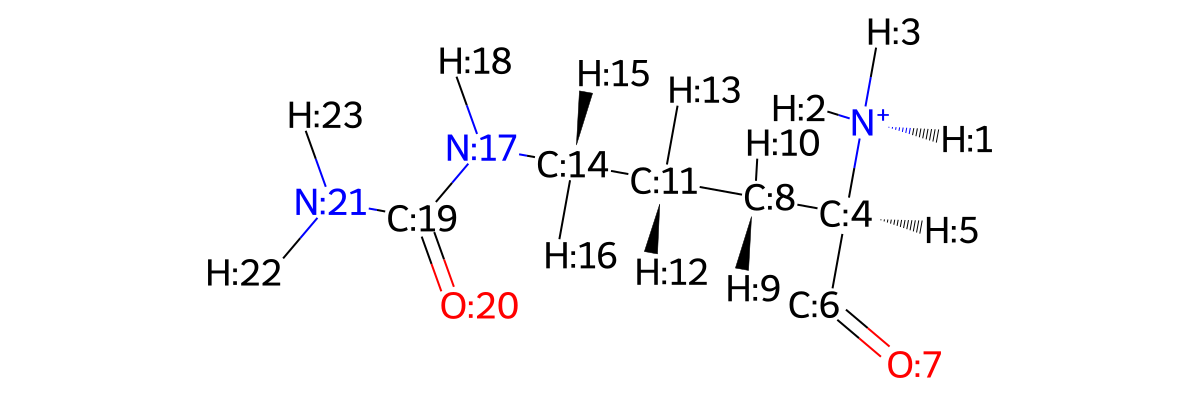

In [34]:
R_CIT_pdb = Chem.MolFromPDBFile('moleculse/substructure/NR_CIT.pdb', removeHs=False)
AllChem.EmbedMolecule(R_CIT_pdb)
AllChem.MMFFOptimizeMolecule(R_CIT_pdb)

# Преобразование трехмерных координат в двумерные
AllChem.Compute2DCoords(R_CIT_pdb)
# Отображение молекулы
for i, atom in enumerate(R_CIT_pdb.GetAtoms()):
    atom.SetAtomMapNum(atom.GetIdx())
display(R_CIT_pdb)

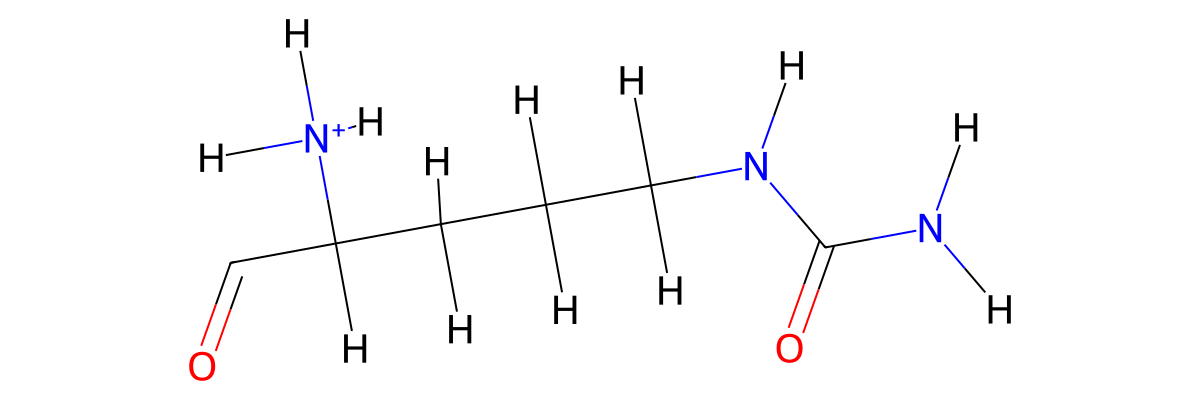

In [12]:
R_CIT_smi = pt.('moleculse/substructure/NR_CIT.mol')
R_CIT_mon = Chem.MolFrom(R_CIT_smi, sanitize=False, )
# R_CIT_full = Chem.AddHs(R_CIT_full)
R_CIT_mon

In [35]:
from rdkit.Chem import AllChem, Draw, rdFMCS
mcs_1 = rdFMCS.FindMCS([R_CIT_pdb, R_pdb], 
                          # atomCompare=rdFMCS.AtomCompare.CompareAny,
                          bondCompare=rdFMCS.BondCompare.CompareAny,
                          ringMatchesRingOnly=False
                         )

i_atoms_in_mol = R_CIT_pdb.GetSubstructMatch(mcs_1.queryMol)
i_atoms_in_PDB = R_pdb.GetSubstructMatch(mcs_1.queryMol)
mol_to_pdb_ind = dict(zip(i_atoms_in_mol, i_atoms_in_PDB))
print(i_atoms_in_mol, i_atoms_in_PDB, mol_to_pdb_ind,  sep='\n')

(0, 1, 2, 3, 4, 5, 6, 8, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23)
(0, 23, 24, 25, 1, 11, 2, 4, 3, 12, 13, 5, 14, 15, 6, 16, 17, 7, 18, 8, 9, 19, 20)
{0: 0, 1: 23, 2: 24, 3: 25, 4: 1, 5: 11, 6: 2, 8: 4, 7: 3, 9: 12, 10: 13, 11: 5, 12: 14, 13: 15, 14: 6, 15: 16, 16: 17, 17: 7, 18: 18, 19: 8, 21: 9, 22: 19, 23: 20}


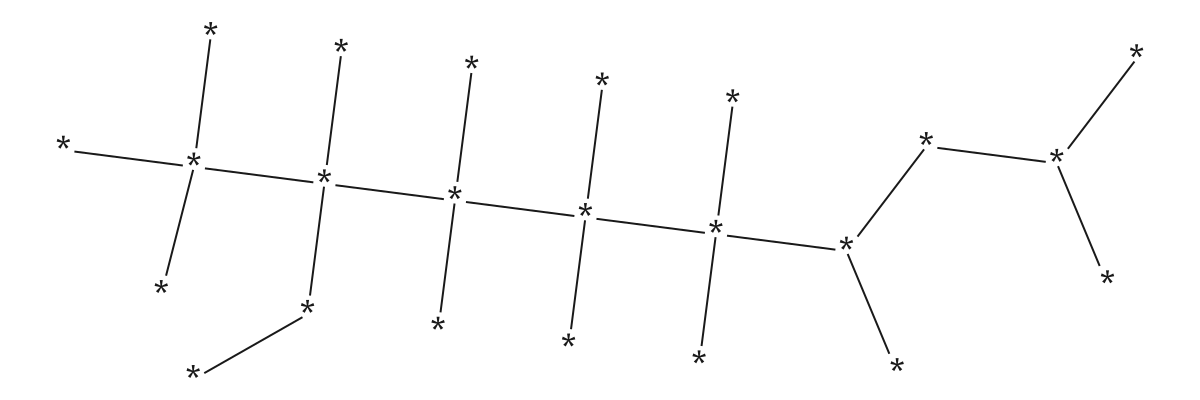

In [36]:
mcs_1.queryMol

In [20]:
type(R_CIT_mon)

rdkit.Chem.rdchem.Mol

In [65]:
with open(f'moleculse/substructure/NR_CIT.pdb', 'r') as mod_aa, open(f'moleculse/aminoacids_template/NR.pdb', 'r') as aa:
        atom_name = []
        mod_aa_names = {}
        aa_names = {}
        for line in aa:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                # print(line.split())
                atom_name = line.split()[2]
                atom_num = int(line.split()[1])
                aa_names[atom_num] = atom_name
        for line in mod_aa:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                # print(line.split())
                atom_name = line.split()[2]
                atom_num = int(line.split()[1])
                mod_aa_names[atom_num] = atom_name


In [67]:
atom_name_dict = {}
for mod_pos, template_pos in mol_to_pdb_ind.items():
    mod_aa_names[mod_pos+1] =  aa_names[template_pos+1]
mod_aa_names

{1: 'N',
 2: 'H1',
 3: 'H2',
 4: 'H3',
 5: 'CA',
 6: 'HA',
 7: 'C',
 8: 'O',
 9: 'CB',
 10: 'HB2',
 11: 'HB3',
 12: 'CG',
 13: 'HG2',
 14: 'HG3',
 15: 'CD',
 16: 'HD2',
 17: 'HD3',
 18: 'NE',
 19: 'HE',
 20: 'CZ',
 21: 'O2',
 22: 'NH1',
 23: 'HH11',
 24: 'HH12'}

In [85]:
rename_atom_pdb = []
with open(f'moleculse/substructure/NR_CIT.pdb', 'r') as mod_aa:
    for line in mod_aa:
        # print(line)
        if line.startswith("ATOM") or line.startswith("HETATM"):
            atom_num = int(line.split()[1])
            atom_name_old = line.split()[2]
            atom_name_new = mod_aa_names[atom_num]
            print(atom_name_old +':'+ atom_name_new)
            new_line = line.replace(atom_name_old, atom_name_new, 1)
            rename_atom_pdb.append(new_line)
        else:
            rename_atom_pdb.append(line)
with open(f'moleculse/substructure/NR_CIT_rename.pdb' , 'w') as file:
    file.write(''.join(rename_atom_pdb))

N1:N
H1:H1
H2:H2
H3:H3
C1:CA
H4:HA
C2:C
O1:O
C3:CB
H5:HB2
H6:HB3
C4:CG
H7:HG2
H8:HG3
C5:CD
H9:HD2
H10:HD3
N2:NE
H11:HE
C6:CZ
O2:O2
N3:NH1
H12:HH11
H13:HH12


In [100]:
nr = mda.Universe('moleculse/substructure/NR_CIT.pdb')
# nr.residues.atoms.names
nr.residues.atoms.names = list(mod_aa_names.values())
nr.atoms.write(f"moleculse/substructure/NR_CIT_mda.pdb")

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1176: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


In [69]:
for i, atom in enumerate(R_CIT_pdb.GetAtoms()):
    atom.SetProp("atom_name", mod_aa_names[i+1]) 
for atom in R_CIT_pdb.GetAtoms():
    print(f"Atom Index: {atom.GetIdx()}, Atom Name: {atom.GetProp('atom_name')}")

Atom Index: 0, Atom Name: N
Atom Index: 1, Atom Name: H1
Atom Index: 2, Atom Name: H2
Atom Index: 3, Atom Name: H3
Atom Index: 4, Atom Name: CA
Atom Index: 5, Atom Name: HA
Atom Index: 6, Atom Name: C
Atom Index: 7, Atom Name: O
Atom Index: 8, Atom Name: CB
Atom Index: 9, Atom Name: HB2
Atom Index: 10, Atom Name: HB3
Atom Index: 11, Atom Name: CG
Atom Index: 12, Atom Name: HG2
Atom Index: 13, Atom Name: HG3
Atom Index: 14, Atom Name: CD
Atom Index: 15, Atom Name: HD2
Atom Index: 16, Atom Name: HD3
Atom Index: 17, Atom Name: NE
Atom Index: 18, Atom Name: HE
Atom Index: 19, Atom Name: CZ
Atom Index: 20, Atom Name: O2
Atom Index: 21, Atom Name: NH1
Atom Index: 22, Atom Name: HH11
Atom Index: 23, Atom Name: HH12


In [1]:
!pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


In [7]:
u = mda.Universe('moleculse/RRR_CIT_H.pdb')
sel = u.select_atoms('resid 1')
sel
sel.write('moleculse/NR_CIT_name.pdb')

[16:59:21] Molecule does not have explicit Hs. Consider calling AddHs()
[16:59:21] Molecule does not have explicit Hs. Consider calling AddHs()


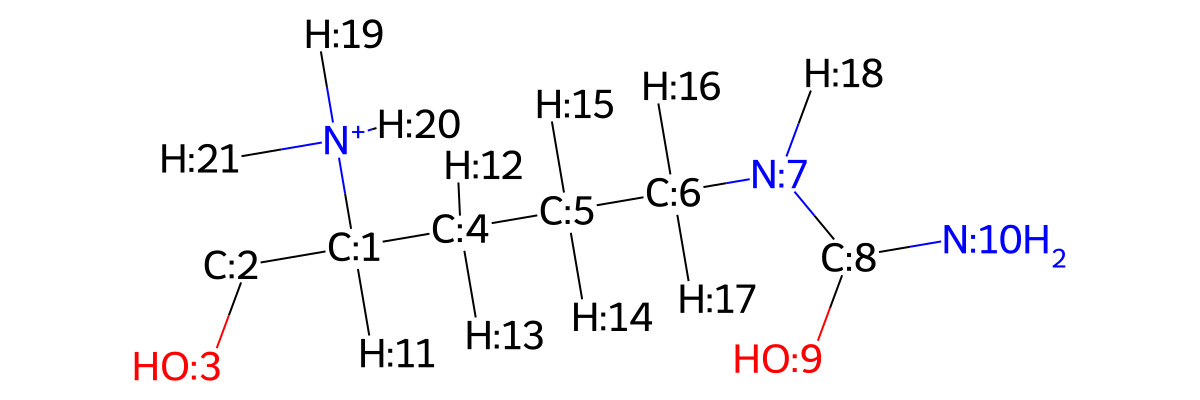

In [8]:
R_CIT_pdb = Chem.MolFromPDBFile('moleculse/NR_CIT_name.pdb', removeHs=False)
AllChem.EmbedMolecule(R_CIT_pdb)
AllChem.MMFFOptimizeMolecule(R_CIT_pdb)

# Преобразование трехмерных координат в двумерные
AllChem.Compute2DCoords(R_CIT_pdb)
# Отображение молекулы
for i, atom in enumerate(R_CIT_pdb.GetAtoms()):
    atom.SetAtomMapNum(atom.GetIdx())
display(R_CIT_pdb)

## Делаем raw  rtp

In [17]:
def make_rtp_fromgmx(g_parm,charges,name, c5=[],c3=[],shift = 0,):
    rtptext=[f'[ {name} ]\n']
    rtptext.append('[ atoms ]\n')
    for i,a in enumerate(g_parm.atoms):
        rtptext.append("%5s%5s%8.4f%4d\n"% (a.name, a.atom_type, charges[i], a.idx +shift))
    rtptext.append('[ bonds ]\n')
    for b in g_parm.bonds:
        rtptext.append("%5s%5s%8.4f%12.1f\n" % (b.atom1.name, b.atom2.name, 0.1*b.type.req, b.type.k*2*4.184*100))
    rtptext.append('[ angles ]\n')
    for a in g_parm.angles:
    #rtptext += "%5s%5s%5s %8.4f %12.1f\n" % (a.atom1.name, a.atom2.name,a.atom3.name, a.type.theteq, a.type.k*1000)
        rtptext.append("%5s%5s%5s %8.4f %12.1f\n" % (a.atom1.name, a.atom2.name,a.atom3.name, 
                                              a.type.theteq, a.type.k*2*4.184))
    rtptext.append('[ dihedrals ]\n')
    for d in g_parm.dihedrals:
        if d.funct == 9:
            rtptext.append("%5s%5s%5s%5s %8.3f %8.4f %5i\n" % (d.atom1.name,d.atom2.name,d.atom3.name,d.atom4.name,
                                                          d.type[0].phase,d.type[0].phi_k*4.184 ,d.type[0].per))
    rtptext.append('[ impropers ]\n')
    for d in g_parm.dihedrals:
        if d.funct == 4:
            rtptext.append("%5s%5s%5s%5s %8.3f %8.4f %5i\n" % (d.atom1.name,d.atom2.name,d.atom3.name,d.atom4.name,
                                                           d.type.phase,d.type.phi_k,d.type.per ))
    out = ''.join(rtptext)    
    
    return out

In [25]:
!pwd

/home/_shared/_projects/2022_md_FRET_nv/param_R_CIT


In [31]:
acpype_name = 'arginine_citrullination_out_H'
top = gromacs.GromacsTopologyFile(f"{acpype_name}.acpype/{acpype_name}_GMX.itp")
with open('Charge_list/R_CIT.json', 'r') as f:
    charge_list = json.load(f)

print(len(top.atoms), len(charge_list))

24 22


In [37]:
top

<GromacsTopologyFile 24 atoms; 1 residues; 23 bonds; parametrized>

In [ ]:
rtp  = make_rtp_fromgmx(top,charges=ch[n],name=n)
with open(f'GMX_system/{n}_raw.rtp' , 'w') as f: 
        # Acpype_full_mol/{n}.acpype/
    f.write(rtp)

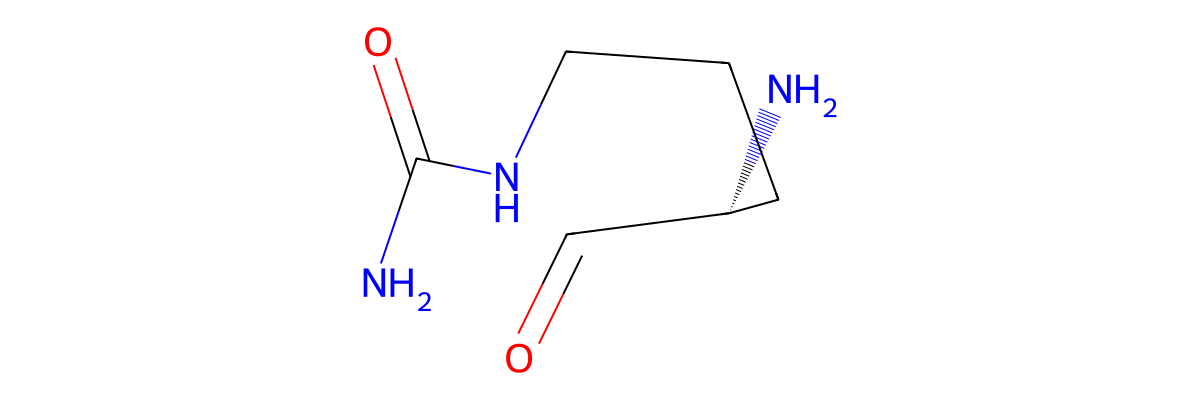

In [7]:
molecule = Chem.MolFromMol2File('moleculse/arginine_citrullination_out_H.mol2')
display(molecule)